In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import copy
pd.set_option('display.max_columns', None)
%config Completer.use_jedi = False

In [2]:
location_juli_1 = r'C:\Users\jlizarraga\Documents\datathon-datasets\train.csv'
location_juli_2 = r'C:\Users\jlizarraga\Documents\datathon-datasets\metadata.csv'

location_fer_1 = r'C:\Users\fmrodriguez\Competencia\datathon-recomendacion\train.csv'
location_fer_2 = r'C:\Users\fmrodriguez\Competencia\datathon-recomendacion\metadata.csv'


# Cada uno tiene que cambiar la dirección de los datasets cuando corra la notebook.
df = pd.read_csv(location_juli_1)
metadata = pd.read_csv(location_juli_2, sep=';')

print(df.shape)
print(metadata.shape)

(3657801, 7)
(33144, 30)


In [3]:
df.head()

,customer_id,account_id,device_type,asset_id,tunein,tuneout,resume
0,0,90627,STATIONARY,18332.0,2021-02-18 22:52:00.0,2021-02-18 23:35:00.0,0
1,0,90627,STATIONARY,24727.0,2021-03-24 23:17:00.0,2021-03-25 00:01:00.0,0
2,1,3387,STB,895.0,2021-03-15 10:05:00.0,2021-03-15 10:23:00.0,0
3,1,3387,STB,895.0,2021-03-15 10:23:00.0,2021-03-15 11:18:00.0,1
4,1,3387,STB,26062.0,2021-03-16 09:24:00.0,2021-03-16 09:44:00.0,0


In [4]:
print('Cantidad de usuarios únicos:')
len(df.account_id.unique())

Cantidad de usuarios únicos:


113881

In [5]:
metadata.head(2)

,asset_id,content_id,title,reduced_title,episode_title,show_type,released_year,country_of_origin,category,keywords,description,reduced_desc,cast_first_name,credits_first_name,run_time_min,audience,made_for_tv,close_caption,sex_rating,violence_rating,language_rating,dialog_rating,fv_rating,pay_per_view,pack_premium_1,pack_premium_2,create_date,modify_date,start_vod_date,end_vod_date
0,15188,0.0,Ep:17 Tiempos Compulsivos,Tiempos_Compul_E17,Episodio 17,Serie,2012.0,AR,Drama,"Trastornos,Médicos,Tragicómica,Telenovela,Enfe...",Esteban recibe una noticia inesperada: va a se...,Esteban recibe una noticia inesperada: va a se...,"Rodrigo De la Serna, Paola Krum, Fernán Mirás,...",Daniel Barone,48.0,General,N,N,N,N,N,N,N,N,N,N,2017-12-01T10:18:15.0Z,2019-01-26T06:37:18.0Z,2017-12-01T00:00:00.0Z,2020-12-01T23:59:59.0Z
1,24940,1.0,7 Cajas,7_Cajas,NaN,Película,2012.0,PY,Suspenso/Acción,"Latinoamérica,Pobreza,Crimen,Pandillas",Víctor trabaja como carretillero. Un día recib...,"Trabajando como carretillero, Víctor recibe un...","Celso Franco, Víctor Sosa, Lali Gonzalez",Juan Carlos Maneglia,105.0,General,N,N,N,N,N,N,N,Y,N,N,2017-12-19T20:58:15.0Z,2019-09-17T19:02:03.0Z,2017-12-15T00:00:00.0Z,2022-12-14T23:59:59.0Z


In [6]:
len(metadata.content_id.unique())

4367

In [7]:
print(len(metadata.credits_first_name.unique()))
print(len(metadata.audience.unique()))

3260
11


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3657801 entries, 0 to 3657800
Data columns (total 7 columns):
 #   Column       Dtype  
---  ------       -----  
 0   customer_id  int64  
 1   account_id   int64  
 2   device_type  object 
 3   asset_id     float64
 4   tunein       object 
 5   tuneout      object 
 6   resume       int64  
dtypes: float64(1), int64(3), object(3)
memory usage: 195.3+ MB


In [9]:
metadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33144 entries, 0 to 33143
Data columns (total 30 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   asset_id            33144 non-null  int64  
 1   content_id          33123 non-null  float64
 2   title               33144 non-null  object 
 3   reduced_title       33144 non-null  object 
 4   episode_title       28997 non-null  object 
 5   show_type           33140 non-null  object 
 6   released_year       33144 non-null  float64
 7   country_of_origin   33140 non-null  object 
 8   category            33144 non-null  object 
 9   keywords            33142 non-null  object 
 10  description         33142 non-null  object 
 11  reduced_desc        33144 non-null  object 
 12  cast_first_name     24412 non-null  object 
 13  credits_first_name  20590 non-null  object 
 14  run_time_min        33144 non-null  float64
 15  audience            33143 non-null  object 
 16  made

In [10]:
# Borramos columnas que no sirven o tienen muchos nulos.

to_delete = ['title', 'reduced_title', 'episode_title', 'description', 'reduced_desc', 'create_date', 'modify_date', 'start_vod_date', 'end_vod_date']
metadata = metadata.drop(columns=to_delete)

In [11]:
# Esta función pasa de string a datetime las columnas que se desea.

def cast_object_to_datetime(df, columns, the_format):
    
    for column in columns:
        
        df[column] = df[column].apply(lambda x: x if x is None else datetime.strptime(x[:-2], the_format))
        
    return df

In [12]:
# Transformamos a datetime las columnas 'tunein' y 'tuneout'
df = cast_object_to_datetime(df, ['tunein', 'tuneout'], '%Y-%m-%d %H:%M:%S')

In [13]:
# Creamos una columna que sea el tiempo que la persona estuvo mirando la serie/película.
# Es la diferencia entre cuando empezó y cuando terminó.

df['time_watching'] = df['tuneout'] - df['tunein']
df = df.drop(columns=['tunein', 'tuneout'])

In [14]:
# Pasamos esa columna nueva de tipo timedelta a float para que sea más fácil de usar.
# Luego obtenemos algunas métricas sobre el tiempo que pasa la gente viendo las series/películas.

df['time_watching'] = df['time_watching'].apply(lambda x: x.total_seconds() / 60)
df[['time_watching']].describe()

,time_watching
count,3.657801e+06
mean,2.697473e+01
std,2.938743e+01
min,2.000000e+00
25%,7.000000e+00
50%,1.700000e+01
75%,3.900000e+01
max,2.400000e+02


(array([2396795.,  704904.,  286120.,  134362.,   78246.,   25482.,
          12785.,    8316.,    6127.,    4664.]),
 array([  2. ,  25.8,  49.6,  73.4,  97.2, 121. , 144.8, 168.6, 192.4,
        216.2, 240. ]),
 <BarContainer object of 10 artists>)

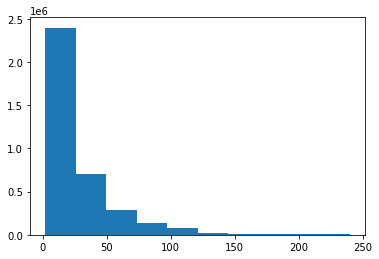

In [15]:
plt.hist(df.time_watching)

C:\Users\jlizarraga\Anaconda3\envs\practia\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='time_watching'>

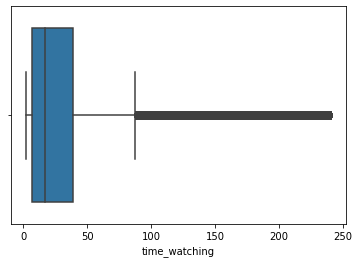

In [16]:
sns.boxplot(df.time_watching)

In [17]:
# Vemos cuáles son los tipos de dispositivo más usados.
# No sabemos si sirve para el modelo.

df.device_type.value_counts()

STB             2993554
STATIONARY       224711
PHONE            216474
CLOUD_CLIENT     174522
TABLET            48511
Name: device_type, dtype: int64

In [18]:
# Dropeamos la columna 'customer_id' porque no es relevante para el análisis. Solo nos sirve 'account_id'.

df = df.drop(columns=['customer_id'])

In [19]:
metadata.show_type.value_counts()

TV              15681
Serie           10905
Película         4025
Web              1386
Gaming            844
Rolling           275
Tutorial           21
Series,Serie        3
Name: show_type, dtype: int64

In [20]:
dict_to_replace_category = {'Accion':'Acción', 'Aventuras':'Aventura', 'Dibujos animados':'Dibujos Animados', 'Ciencia ficción':'Ciencia Ficción',
                           'Familia':'Familiar', 'Infantil, Comedia':'Infantil/Comedia'}

metadata.category.replace(dict_to_replace_category, inplace=True, regex=True)
metadata.show_type.replace({'Series,Serie':'Serie'}, inplace=True)

Text(0.5, 1.0, 'Cantidad de shows por tipo')

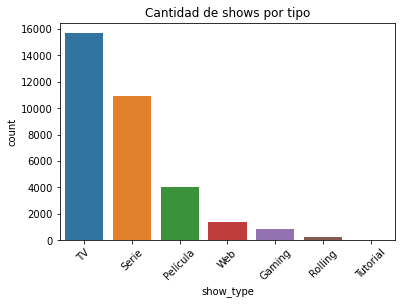

In [21]:
sns.countplot(x='show_type', data=metadata, order=metadata.show_type.value_counts().index)
plt.xticks(rotation=45)
plt.title('Cantidad de shows por tipo')

Text(0.5, 1.0, 'Cantidad de shows por audiencia a la que están dirigidos')

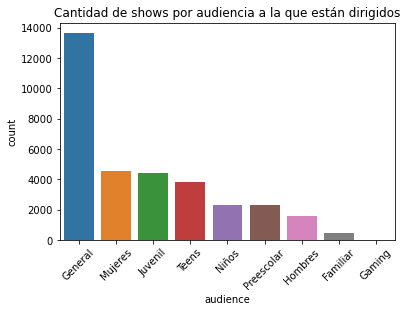

In [22]:
metadata['audience'] = metadata['audience'].str.title()

sns.countplot(x='audience', data=metadata, order=metadata.audience.value_counts().index)
plt.xticks(rotation=45)
plt.title('Cantidad de shows por audiencia a la que están dirigidos')

#### No le den pelota a la celda que está justo acá abajo. Es algo que intenté, pero después me di cuenta de que estaba mal. La dejé toda comentada para que no pase nada si la corren sin querer.

#### No la borro solo _por las dudas_.

#### Lo que está de ahí en adelante sí sirve.

In [23]:
# # Esta función se utiliza cuando hay una columna que tiene registros con dos o más valores separador por algún delimitador (e.g. una coma o un espacio).
# # La función crea N nuevas columnas para almacenar cada valor por separado. 
# # N está dada por la cantidad de valores que tiene la fila con mayor cantidad de valores separados por el delimitador.

# # Recibe como parámetros un DataFrame (df), la columna que se desea separar (column_to_split) y el delimitador presente en dicha columna (delimiter).

# def split_column(df, column_to_split, delimiter):
    
#     max_number_of_splits = df[column_to_split].str.count(delimiter).max()
#     list_of_new_columns = []
    
#     for n in range(1, int(max_number_of_splits)+2):
#         list_of_new_columns.append(column_to_split+'_{}'.format(n))
        
#     df[list_of_new_columns] = df[column_to_split].str.split(delimiter, expand=True)
#     df.drop(columns=[column_to_split], inplace=True)
    
#     return df

# # Hay activos que tienen dos categorías en lugar de una, por lo cual vamos a usar dos columnas para las categorías en lugar de una.
# # Los activos que tengan dos categorías tendrán una en cada columna; los que tengan solo una tendrán un None en 'category_2'.
# metadata = split_column(metadata, 'category', '/')

# # Hacemos que cada palabra del string comience con mayúscula.
# metadata['category_1'] = metadata['category_1'].str.title()
# metadata['category_2'] = metadata['category_2'].str.title()

# # Hacemos lo mismo que con la columna 'category', pero con la columna 'keywords'.

# metadata = split_column(metadata, 'keywords', ',')

In [24]:
# Esta función crea las dummies para alguna columna.

# Si se pasa algún delimitador (delimiter), crea las dummies de una columna en la cual haya múltiples valores por fila.
# Por ejemplo, la columna 'category' tiene filas que dicen 'Suspenso/Terror'. 
# En ese caso se crean dos columnas ('Suspenso' y 'Terror') y se le pone un 1 a ese registro.
# Los parámetros que recibe son un DataFrame, una columna, un delimitador (en nuestro ejemplo: '/') y un prefijo para las nuevas columnas (opcional).

def create_dummies(df, column, delimiter=None, prefix=None):

    if delimiter is not None: # Si entra acá es porque hay múltiples valores en cada fila separados por algún delimitador.
    
        if prefix is None:
            prefix = column + '_'

        df = df.merge(df[column].str.get_dummies(sep=delimiter).add_prefix(prefix), left_index=True, right_index=True)
        
    else: # Si entra acá es porque cada fila tiene un solo valor. Es básicamente un pd.get_dummies convencional.
        
        dummy_columns = pd.get_dummies(df[column], prefix=column)
        df = pd.concat([df, dummy_columns], axis=1)

    df.drop(columns=[column], inplace=True)
        
    return df

In [25]:
metadata = create_dummies(metadata, 'category', '/')
metadata = create_dummies(metadata, 'keywords', ',')
metadata = create_dummies(metadata, 'show_type')
metadata = create_dummies(metadata, 'country_of_origin')
metadata = create_dummies(metadata, 'audience')

In [26]:
# Las siguientes columnas tienen 'N' e 'Y' representando 'No' y 'Yes'.
# Cambiamos las N por 0 y las Y por 1.

metadata.loc[:, ['made_for_tv', 'close_caption', 'sex_rating', 'violence_rating', 'language_rating', 'dialog_rating',
                 'fv_rating', 'pay_per_view', 'pack_premium_1', 'pack_premium_2']] = metadata[['made_for_tv', 'close_caption', 'sex_rating', 'violence_rating', 'language_rating', 'dialog_rating',
                                                                                               'fv_rating', 'pay_per_view', 'pack_premium_1', 'pack_premium_2']].replace({'N':0, 'Y':1})

In [27]:
# Tomamos una persona al azar para probar recomendarle algo.

persona_102343 = df[df.account_id==102343].join(metadata.set_index('asset_id'), on='asset_id', rsuffix='_metadata')

In [28]:
persona_102343.asset_id.value_counts()

2967.0     172
26230.0    115
15046.0     60
5567.0      55
11095.0     53
          ... 
3205.0       1
21117.0      1
30242.0      1
16565.0      1
32602.0      1
Name: asset_id, Length: 72, dtype: int64

# Prueba falopa

In [65]:
metadata_de_chequeo = pd.read_csv(location_juli_2, sep=';')

In [71]:
pd.set_option('display.max_columns', 10)

In [29]:
persona = persona_102343.drop(columns=['account_id', 'device_type', 'resume', 'time_watching', 'released_year', 'cast_first_name',
                            'credits_first_name', 'run_time_min'])

In [30]:
persona

,asset_id,content_id,made_for_tv,close_caption,sex_rating,violence_rating,language_rating,dialog_rating,fv_rating,pay_per_view,pack_premium_1,pack_premium_2,category_Acción,category_Animación,category_Animales,category_Aventura,category_Biografía,category_Bélico,category_Ciencia,category_Ciencia Ficción,category_Cocina,category_Comedia,category_Competencia,category_Crimen,category_Cultura,category_Decodificador Flow,category_Deporte,category_Dibujos Animados,category_Documental,category_Drama,category_Entretenimiento,category_Entrevistas,category_Espectáculo,category_Familiar,category_Familiarr,category_Fantasía,category_Historia,category_Humor,category_Infantil,category_Interés General,category_Investigación,category_Magazine,category_Moda,category_Musical,category_Música,category_Naturaleza,category_Periodístico,category_Policial,category_Político,category_Reality,category_Religión,category_Restauración,category_Romance,category_Suspenso,category_Teatro,category_Terror,category_Tutoriales,category_Viajes,category_Western,keywords_ Africa,keywords_ Bizarras,keywords_ Medieval,keywords_20s,keywords_30s,keywords_40s,keywords_50s,keywords_60s,keywords_70s,keywords_80s,keywords_90s,keywords_Abogados,keywords_Abusos,keywords_Accidentes,keywords_Aclamadas,keywords_Actualidad,keywords_Adicciones,keywords_Adolescentes,keywords_Adrenalina,keywords_Aeropuerto,keywords_Africa,keywords_Agentes,keywords_Aislados,keywords_Aliens,keywords_Amigos,keywords_Amistad,keywords_Amor,keywords_Androides,keywords_Animación,keywords_Animales,keywords_Animé,keywords_Antihéroes,keywords_Antiprincesas,keywords_Antisistema,keywords_Apocalipsis,keywords_Apocalípsis,keywords_Armas,keywords_Arte,keywords_Artes Marciales,keywords_Artistas,keywords_Asesinos,keywords_Asia,keywords_Asiáticos,keywords_Astronautas,keywords_Autos,keywords_Aventuras,keywords_Aves,keywords_Aviones,keywords_Avión,keywords_BYN,keywords_Backstage,keywords_Bailarines,keywords_Baile,keywords_Barcos,keywords_Belleza,keywords_Biblia,keywords_Biografía,keywords_Bizarra,keywords_Bizarras,keywords_Bosque,keywords_Boxeo,keywords_Brujas,keywords_Burdel,keywords_Caballos,keywords_Canciones,keywords_Canibalismo,keywords_Casamiento,keywords_Casino,keywords_Catástrofes,keywords_Celebridades,keywords_Ciencia,keywords_Cine,keywords_Circo,keywords_Ciudad,keywords_Clásicas,keywords_Cocineros,keywords_Comedia,keywords_Comics,keywords_Comidas,keywords_Competencia,keywords_Congelados,keywords_Conspirativas,keywords_Corporación,keywords_Corrupción,keywords_Crecer,keywords_Criaturas,keywords_Crimen,keywords_Criminales,keywords_Culto,keywords_Cultura,keywords_Cómic,keywords_DC Comics,keywords_De Color,keywords_De Libros,keywords_De libros,keywords_Decoración,keywords_Deportistas,keywords_Depredadores,keywords_Desamor,keywords_Desierto,keywords_Despecho,keywords_Detectives,keywords_Dictadores,keywords_Dimensiones,keywords_Dinero,keywords_Dinosaurios,keywords_Director,keywords_Directores,keywords_Diseño,keywords_Disney,keywords_Distopía,keywords_Divorcio,keywords_Dragones,keywords_Dreamworks,keywords_Droga,keywords_Educativo,keywords_Embarazos,keywords_Emmy,keywords_Empresarios,keywords_Encierro,keywords_Enfermedades,keywords_Entretenimiento,keywords_Entrevistas,keywords_Erótica,keywords_Escritores,keywords_Escuela,keywords_Espacio,keywords_Espectaculos,keywords_Espectáculos,keywords_Espionaje,keywords_Espíritus,keywords_Estafas,keywords_Europa,keywords_Exorcismo,keywords_Experimentos,keywords_Exploración,keywords_Familia,keywords_Fantasía,keywords_Feminismo,keywords_Fiestas,keywords_Flow,keywords_Futurismo,keywords_Fútbol,keywords_Fútbol Americano,keywords_Galaxia,keywords_Gaming,keywords_Genios,keywords_Gobierno,keywords_Golden Globe,keywords_Granja,keywords_Guerra,keywords_Guerra Mudial,keywords_Guerra Mundial,keywords_Guerreros,keywords_Hackers,keywords_Halloween,keywords_Hechiceros,keywords_Hechos Reales,keywords_Hechos reales,keywords_Hermanos,keywords_Historia,keywords_Historias Cruzadas,keywords_Hockey,

In [31]:
persona_clean = persona[~persona.content_id.duplicated()]

In [32]:
persona_clean

,asset_id,content_id,made_for_tv,close_caption,sex_rating,violence_rating,language_rating,dialog_rating,fv_rating,pay_per_view,pack_premium_1,pack_premium_2,category_Acción,category_Animación,category_Animales,category_Aventura,category_Biografía,category_Bélico,category_Ciencia,category_Ciencia Ficción,category_Cocina,category_Comedia,category_Competencia,category_Crimen,category_Cultura,category_Decodificador Flow,category_Deporte,category_Dibujos Animados,category_Documental,category_Drama,category_Entretenimiento,category_Entrevistas,category_Espectáculo,category_Familiar,category_Familiarr,category_Fantasía,category_Historia,category_Humor,category_Infantil,category_Interés General,category_Investigación,category_Magazine,category_Moda,category_Musical,category_Música,category_Naturaleza,category_Periodístico,category_Policial,category_Político,category_Reality,category_Religión,category_Restauración,category_Romance,category_Suspenso,category_Teatro,category_Terror,category_Tutoriales,category_Viajes,category_Western,keywords_ Africa,keywords_ Bizarras,keywords_ Medieval,keywords_20s,keywords_30s,keywords_40s,keywords_50s,keywords_60s,keywords_70s,keywords_80s,keywords_90s,keywords_Abogados,keywords_Abusos,keywords_Accidentes,keywords_Aclamadas,keywords_Actualidad,keywords_Adicciones,keywords_Adolescentes,keywords_Adrenalina,keywords_Aeropuerto,keywords_Africa,keywords_Agentes,keywords_Aislados,keywords_Aliens,keywords_Amigos,keywords_Amistad,keywords_Amor,keywords_Androides,keywords_Animación,keywords_Animales,keywords_Animé,keywords_Antihéroes,keywords_Antiprincesas,keywords_Antisistema,keywords_Apocalipsis,keywords_Apocalípsis,keywords_Armas,keywords_Arte,keywords_Artes Marciales,keywords_Artistas,keywords_Asesinos,keywords_Asia,keywords_Asiáticos,keywords_Astronautas,keywords_Autos,keywords_Aventuras,keywords_Aves,keywords_Aviones,keywords_Avión,keywords_BYN,keywords_Backstage,keywords_Bailarines,keywords_Baile,keywords_Barcos,keywords_Belleza,keywords_Biblia,keywords_Biografía,keywords_Bizarra,keywords_Bizarras,keywords_Bosque,keywords_Boxeo,keywords_Brujas,keywords_Burdel,keywords_Caballos,keywords_Canciones,keywords_Canibalismo,keywords_Casamiento,keywords_Casino,keywords_Catástrofes,keywords_Celebridades,keywords_Ciencia,keywords_Cine,keywords_Circo,keywords_Ciudad,keywords_Clásicas,keywords_Cocineros,keywords_Comedia,keywords_Comics,keywords_Comidas,keywords_Competencia,keywords_Congelados,keywords_Conspirativas,keywords_Corporación,keywords_Corrupción,keywords_Crecer,keywords_Criaturas,keywords_Crimen,keywords_Criminales,keywords_Culto,keywords_Cultura,keywords_Cómic,keywords_DC Comics,keywords_De Color,keywords_De Libros,keywords_De libros,keywords_Decoración,keywords_Deportistas,keywords_Depredadores,keywords_Desamor,keywords_Desierto,keywords_Despecho,keywords_Detectives,keywords_Dictadores,keywords_Dimensiones,keywords_Dinero,keywords_Dinosaurios,keywords_Director,keywords_Directores,keywords_Diseño,keywords_Disney,keywords_Distopía,keywords_Divorcio,keywords_Dragones,keywords_Dreamworks,keywords_Droga,keywords_Educativo,keywords_Embarazos,keywords_Emmy,keywords_Empresarios,keywords_Encierro,keywords_Enfermedades,keywords_Entretenimiento,keywords_Entrevistas,keywords_Erótica,keywords_Escritores,keywords_Escuela,keywords_Espacio,keywords_Espectaculos,keywords_Espectáculos,keywords_Espionaje,keywords_Espíritus,keywords_Estafas,keywords_Europa,keywords_Exorcismo,keywords_Experimentos,keywords_Exploración,keywords_Familia,keywords_Fantasía,keywords_Feminismo,keywords_Fiestas,keywords_Flow,keywords_Futurismo,keywords_Fútbol,keywords_Fútbol Americano,keywords_Galaxia,keywords_Gaming,keywords_Genios,keywords_Gobierno,keywords_Golden Globe,keywords_Granja,keywords_Guerra,keywords_Guerra Mudial,keywords_Guerra Mundial,keywords_Guerreros,keywords_Hackers,keywords_Halloween,keywords_Hechiceros,keywords_Hechos Reales,keywords_Hechos reales,keywords_Hermanos,keywords_Historia,keywords_Historias Cruzadas,keywords_Hockey,

In [33]:
metadata[metadata.asset_id==31287.0]

,asset_id,content_id,released_year,cast_first_name,credits_first_name,run_time_min,made_for_tv,close_caption,sex_rating,violence_rating,language_rating,dialog_rating,fv_rating,pay_per_view,pack_premium_1,pack_premium_2,category_Acción,category_Animación,category_Animales,category_Aventura,category_Biografía,category_Bélico,category_Ciencia,category_Ciencia Ficción,category_Cocina,category_Comedia,category_Competencia,category_Crimen,category_Cultura,category_Decodificador Flow,category_Deporte,category_Dibujos Animados,category_Documental,category_Drama,category_Entretenimiento,category_Entrevistas,category_Espectáculo,category_Familiar,category_Familiarr,category_Fantasía,category_Historia,category_Humor,category_Infantil,category_Interés General,category_Investigación,category_Magazine,category_Moda,category_Musical,category_Música,category_Naturaleza,category_Periodístico,category_Policial,category_Político,category_Reality,category_Religión,category_Restauración,category_Romance,category_Suspenso,category_Teatro,category_Terror,category_Tutoriales,category_Viajes,category_Western,keywords_ Africa,keywords_ Bizarras,keywords_ Medieval,keywords_20s,keywords_30s,keywords_40s,keywords_50s,keywords_60s,keywords_70s,keywords_80s,keywords_90s,keywords_Abogados,keywords_Abusos,keywords_Accidentes,keywords_Aclamadas,keywords_Actualidad,keywords_Adicciones,keywords_Adolescentes,keywords_Adrenalina,keywords_Aeropuerto,keywords_Africa,keywords_Agentes,keywords_Aislados,keywords_Aliens,keywords_Amigos,keywords_Amistad,keywords_Amor,keywords_Androides,keywords_Animación,keywords_Animales,keywords_Animé,keywords_Antihéroes,keywords_Antiprincesas,keywords_Antisistema,keywords_Apocalipsis,keywords_Apocalípsis,keywords_Armas,keywords_Arte,keywords_Artes Marciales,keywords_Artistas,keywords_Asesinos,keywords_Asia,keywords_Asiáticos,keywords_Astronautas,keywords_Autos,keywords_Aventuras,keywords_Aves,keywords_Aviones,keywords_Avión,keywords_BYN,keywords_Backstage,keywords_Bailarines,keywords_Baile,keywords_Barcos,keywords_Belleza,keywords_Biblia,keywords_Biografía,keywords_Bizarra,keywords_Bizarras,keywords_Bosque,keywords_Boxeo,keywords_Brujas,keywords_Burdel,keywords_Caballos,keywords_Canciones,keywords_Canibalismo,keywords_Casamiento,keywords_Casino,keywords_Catástrofes,keywords_Celebridades,keywords_Ciencia,keywords_Cine,keywords_Circo,keywords_Ciudad,keywords_Clásicas,keywords_Cocineros,keywords_Comedia,keywords_Comics,keywords_Comidas,keywords_Competencia,keywords_Congelados,keywords_Conspirativas,keywords_Corporación,keywords_Corrupción,keywords_Crecer,keywords_Criaturas,keywords_Crimen,keywords_Criminales,keywords_Culto,keywords_Cultura,keywords_Cómic,keywords_DC Comics,keywords_De Color,keywords_De Libros,keywords_De libros,keywords_Decoración,keywords_Deportistas,keywords_Depredadores,keywords_Desamor,keywords_Desierto,keywords_Despecho,keywords_Detectives,keywords_Dictadores,keywords_Dimensiones,keywords_Dinero,keywords_Dinosaurios,keywords_Director,keywords_Directores,keywords_Diseño,keywords_Disney,keywords_Distopía,keywords_Divorcio,keywords_Dragones,keywords_Dreamworks,keywords_Droga,keywords_Educativo,keywords_Embarazos,keywords_Emmy,keywords_Empresarios,keywords_Encierro,keywords_Enfermedades,keywords_Entretenimiento,keywords_Entrevistas,keywords_Erótica,keywords_Escritores,keywords_Escuela,keywords_Espacio,keywords_Espectaculos,keywords_Espectáculos,keywords_Espionaje,keywords_Espíritus,keywords_Estafas,keywords_Europa,keywords_Exorcismo,keywords_Experimentos,keywords_Exploración,keywords_Familia,keywords_Fantasía,keywords_Feminismo,keywords_Fiestas,keywords_Flow,keywords_Futurismo,keywords_Fútbol,keywords_Fútbol Americano,keywords_Galaxia,keywords_Gaming,keywords_Genios,keywords_Gobierno,keywords_Golden Globe,keywords_Granja,keywords_Guerra,keywords_Guerra Mudial,keywords_Guerra Mundial,keywords_Guerreros,keywords_Hackers,keywords_Halloween,keywords_Hechiceros,keywords_Hechos Reales,keywords_Hechos reales,keywords_Hermanos,

In [34]:
shows = metadata.drop(columns=['asset_id', 'released_year', 'cast_first_name', 'credits_first_name'])

In [35]:
shows_clean = shows[~shows.content_id.duplicated()]
shows_clean

,content_id,run_time_min,made_for_tv,close_caption,sex_rating,violence_rating,language_rating,dialog_rating,fv_rating,pay_per_view,pack_premium_1,pack_premium_2,category_Acción,category_Animación,category_Animales,category_Aventura,category_Biografía,category_Bélico,category_Ciencia,category_Ciencia Ficción,category_Cocina,category_Comedia,category_Competencia,category_Crimen,category_Cultura,category_Decodificador Flow,category_Deporte,category_Dibujos Animados,category_Documental,category_Drama,category_Entretenimiento,category_Entrevistas,category_Espectáculo,category_Familiar,category_Familiarr,category_Fantasía,category_Historia,category_Humor,category_Infantil,category_Interés General,category_Investigación,category_Magazine,category_Moda,category_Musical,category_Música,category_Naturaleza,category_Periodístico,category_Policial,category_Político,category_Reality,category_Religión,category_Restauración,category_Romance,category_Suspenso,category_Teatro,category_Terror,category_Tutoriales,category_Viajes,category_Western,keywords_ Africa,keywords_ Bizarras,keywords_ Medieval,keywords_20s,keywords_30s,keywords_40s,keywords_50s,keywords_60s,keywords_70s,keywords_80s,keywords_90s,keywords_Abogados,keywords_Abusos,keywords_Accidentes,keywords_Aclamadas,keywords_Actualidad,keywords_Adicciones,keywords_Adolescentes,keywords_Adrenalina,keywords_Aeropuerto,keywords_Africa,keywords_Agentes,keywords_Aislados,keywords_Aliens,keywords_Amigos,keywords_Amistad,keywords_Amor,keywords_Androides,keywords_Animación,keywords_Animales,keywords_Animé,keywords_Antihéroes,keywords_Antiprincesas,keywords_Antisistema,keywords_Apocalipsis,keywords_Apocalípsis,keywords_Armas,keywords_Arte,keywords_Artes Marciales,keywords_Artistas,keywords_Asesinos,keywords_Asia,keywords_Asiáticos,keywords_Astronautas,keywords_Autos,keywords_Aventuras,keywords_Aves,keywords_Aviones,keywords_Avión,keywords_BYN,keywords_Backstage,keywords_Bailarines,keywords_Baile,keywords_Barcos,keywords_Belleza,keywords_Biblia,keywords_Biografía,keywords_Bizarra,keywords_Bizarras,keywords_Bosque,keywords_Boxeo,keywords_Brujas,keywords_Burdel,keywords_Caballos,keywords_Canciones,keywords_Canibalismo,keywords_Casamiento,keywords_Casino,keywords_Catástrofes,keywords_Celebridades,keywords_Ciencia,keywords_Cine,keywords_Circo,keywords_Ciudad,keywords_Clásicas,keywords_Cocineros,keywords_Comedia,keywords_Comics,keywords_Comidas,keywords_Competencia,keywords_Congelados,keywords_Conspirativas,keywords_Corporación,keywords_Corrupción,keywords_Crecer,keywords_Criaturas,keywords_Crimen,keywords_Criminales,keywords_Culto,keywords_Cultura,keywords_Cómic,keywords_DC Comics,keywords_De Color,keywords_De Libros,keywords_De libros,keywords_Decoración,keywords_Deportistas,keywords_Depredadores,keywords_Desamor,keywords_Desierto,keywords_Despecho,keywords_Detectives,keywords_Dictadores,keywords_Dimensiones,keywords_Dinero,keywords_Dinosaurios,keywords_Director,keywords_Directores,keywords_Diseño,keywords_Disney,keywords_Distopía,keywords_Divorcio,keywords_Dragones,keywords_Dreamworks,keywords_Droga,keywords_Educativo,keywords_Embarazos,keywords_Emmy,keywords_Empresarios,keywords_Encierro,keywords_Enfermedades,keywords_Entretenimiento,keywords_Entrevistas,keywords_Erótica,keywords_Escritores,keywords_Escuela,keywords_Espacio,keywords_Espectaculos,keywords_Espectáculos,keywords_Espionaje,keywords_Espíritus,keywords_Estafas,keywords_Europa,keywords_Exorcismo,keywords_Experimentos,keywords_Exploración,keywords_Familia,keywords_Fantasía,keywords_Feminismo,keywords_Fiestas,keywords_Flow,keywords_Futurismo,keywords_Fútbol,keywords_Fútbol Americano,keywords_Galaxia,keywords_Gaming,keywords_Genios,keywords_Gobierno,keywords_Golden Globe,keywords_Granja,keywords_Guerra,keywords_Guerra Mudial,keywords_Guerra Mundial,keywords_Guerreros,keywords_Hackers,keywords_Halloween,keywords_Hechiceros,keywords_Hechos Reales,keywords_Hechos reales,keywords_Hermanos,keywords_Historia,keywords_Historias Cruzadas,keywords_Hoc

In [37]:
from sklearn.metrics.pairwise import linear_kernel

In [39]:
cosine_similarities = linear_kernel(persona_clean.drop(columns=['asset_id', 'content_id']), shows_clean.drop(columns=['content_id', 'run_time_min']))

In [40]:
cosine_similarities.shape

(18, 4367)

In [41]:
cosine_similarities

array([[0., 0., 0., ..., 0., 0., 1.],
       [1., 0., 0., ..., 0., 0., 1.],
       [1., 0., 0., ..., 0., 0., 1.],
       ...,
       [1., 0., 0., ..., 0., 0., 1.],
       [1., 0., 0., ..., 0., 0., 1.],
       [1., 2., 1., ..., 4., 3., 2.]])

In [58]:
np.sort(cosine_similarities[-1])[-10:-1]

array([7., 7., 7., 7., 7., 8., 8., 8., 9.])

In [80]:
np.max(cosine_similarities[-1])

10.0

In [47]:
a = pd.DataFrame(cosine_similarities)

In [81]:
for column in a.columns:
   
    if a.loc[17, column] == 10:
        print(column)

519


In [52]:
persona_clean

,asset_id,content_id,made_for_tv,close_caption,sex_rating,violence_rating,language_rating,dialog_rating,fv_rating,pay_per_view,pack_premium_1,pack_premium_2,category_Acción,category_Animación,category_Animales,category_Aventura,category_Biografía,category_Bélico,category_Ciencia,category_Ciencia Ficción,category_Cocina,category_Comedia,category_Competencia,category_Crimen,category_Cultura,category_Decodificador Flow,category_Deporte,category_Dibujos Animados,category_Documental,category_Drama,category_Entretenimiento,category_Entrevistas,category_Espectáculo,category_Familiar,category_Familiarr,category_Fantasía,category_Historia,category_Humor,category_Infantil,category_Interés General,category_Investigación,category_Magazine,category_Moda,category_Musical,category_Música,category_Naturaleza,category_Periodístico,category_Policial,category_Político,category_Reality,category_Religión,category_Restauración,category_Romance,category_Suspenso,category_Teatro,category_Terror,category_Tutoriales,category_Viajes,category_Western,keywords_ Africa,keywords_ Bizarras,keywords_ Medieval,keywords_20s,keywords_30s,keywords_40s,keywords_50s,keywords_60s,keywords_70s,keywords_80s,keywords_90s,keywords_Abogados,keywords_Abusos,keywords_Accidentes,keywords_Aclamadas,keywords_Actualidad,keywords_Adicciones,keywords_Adolescentes,keywords_Adrenalina,keywords_Aeropuerto,keywords_Africa,keywords_Agentes,keywords_Aislados,keywords_Aliens,keywords_Amigos,keywords_Amistad,keywords_Amor,keywords_Androides,keywords_Animación,keywords_Animales,keywords_Animé,keywords_Antihéroes,keywords_Antiprincesas,keywords_Antisistema,keywords_Apocalipsis,keywords_Apocalípsis,keywords_Armas,keywords_Arte,keywords_Artes Marciales,keywords_Artistas,keywords_Asesinos,keywords_Asia,keywords_Asiáticos,keywords_Astronautas,keywords_Autos,keywords_Aventuras,keywords_Aves,keywords_Aviones,keywords_Avión,keywords_BYN,keywords_Backstage,keywords_Bailarines,keywords_Baile,keywords_Barcos,keywords_Belleza,keywords_Biblia,keywords_Biografía,keywords_Bizarra,keywords_Bizarras,keywords_Bosque,keywords_Boxeo,keywords_Brujas,keywords_Burdel,keywords_Caballos,keywords_Canciones,keywords_Canibalismo,keywords_Casamiento,keywords_Casino,keywords_Catástrofes,keywords_Celebridades,keywords_Ciencia,keywords_Cine,keywords_Circo,keywords_Ciudad,keywords_Clásicas,keywords_Cocineros,keywords_Comedia,keywords_Comics,keywords_Comidas,keywords_Competencia,keywords_Congelados,keywords_Conspirativas,keywords_Corporación,keywords_Corrupción,keywords_Crecer,keywords_Criaturas,keywords_Crimen,keywords_Criminales,keywords_Culto,keywords_Cultura,keywords_Cómic,keywords_DC Comics,keywords_De Color,keywords_De Libros,keywords_De libros,keywords_Decoración,keywords_Deportistas,keywords_Depredadores,keywords_Desamor,keywords_Desierto,keywords_Despecho,keywords_Detectives,keywords_Dictadores,keywords_Dimensiones,keywords_Dinero,keywords_Dinosaurios,keywords_Director,keywords_Directores,keywords_Diseño,keywords_Disney,keywords_Distopía,keywords_Divorcio,keywords_Dragones,keywords_Dreamworks,keywords_Droga,keywords_Educativo,keywords_Embarazos,keywords_Emmy,keywords_Empresarios,keywords_Encierro,keywords_Enfermedades,keywords_Entretenimiento,keywords_Entrevistas,keywords_Erótica,keywords_Escritores,keywords_Escuela,keywords_Espacio,keywords_Espectaculos,keywords_Espectáculos,keywords_Espionaje,keywords_Espíritus,keywords_Estafas,keywords_Europa,keywords_Exorcismo,keywords_Experimentos,keywords_Exploración,keywords_Familia,keywords_Fantasía,keywords_Feminismo,keywords_Fiestas,keywords_Flow,keywords_Futurismo,keywords_Fútbol,keywords_Fútbol Americano,keywords_Galaxia,keywords_Gaming,keywords_Genios,keywords_Gobierno,keywords_Golden Globe,keywords_Granja,keywords_Guerra,keywords_Guerra Mudial,keywords_Guerra Mundial,keywords_Guerreros,keywords_Hackers,keywords_Halloween,keywords_Hechiceros,keywords_Hechos Reales,keywords_Hechos reales,keywords_Hermanos,keywords_Historia,keywords_Historias Cruzadas,keywords_Hockey,

In [77]:
metadata_de_chequeo[metadata_de_chequeo.asset_id==31287]

,asset_id,content_id,title,reduced_title,episode_title,...,pack_premium_2,create_date,modify_date,start_vod_date,end_vod_date
25559,31287,518.0,Creed 2,Creed_2,NaN,...,N,2020-11-23T17:48:45.0Z,2020-12-20T23:06:05.0Z,2020-12-15T00:00:00.0Z,2022-11-20T23:59:00.0Z


In [82]:
metadata_de_chequeo[~metadata_de_chequeo.content_id.duplicated()].iloc[[519, 522, 294, 296, 297], :]

,asset_id,content_id,title,reduced_title,episode_title,...,pack_premium_2,create_date,modify_date,start_vod_date,end_vod_date
3126,1220,518.0,Creed 2,Creed_2,NaN,...,N,2020-11-06T21:24:37.0Z,2020-11-24T06:34:47.0Z,2020-11-20T00:00:00.0Z,2020-12-14T23:59:59.0Z
3129,26831,521.0,Creed: Corazón de campeón,Creed__Corazon_de_c,NaN,...,N,2020-11-07T01:39:53.0Z,2020-11-24T06:37:49.0Z,2020-11-20T00:00:00.0Z,2020-12-14T23:59:59.0Z
1486,15320,294.0,Rocky Balboa,Rocky_Balboa,NaN,...,N,2018-11-15T18:28:26.0Z,2020-11-23T22:17:05.0Z,2018-11-15T00:00:00.0Z,2020-12-14T23:59:59.0Z
1495,21100,296.0,Rocky III,Rocky_III,NaN,...,N,2018-11-20T15:06:16.0Z,2020-11-24T08:49:00.0Z,2018-11-15T00:00:00.0Z,2020-12-14T23:59:59.0Z
1496,229,297.0,Rocky V,Rocky_V,NaN,...,N,2018-11-20T15:09:17.0Z,2020-11-24T08:52:03.0Z,2018-11-15T00:00:00.0Z,2020-12-14T23:59:59.0Z
